<a href="https://colab.research.google.com/github/ermiasmikael/bert_fine_tuned/blob/master/model_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fuzzywuzzy

In [1]:
# General imports
import os
import json
import warnings
from collections import Counter
import random

import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Data handling and preprocessing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# PyTorch and Transformers
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.nn.utils import clip_grad_norm_
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoConfig,
    AdamW,
    get_linear_schedule_with_warmup,
    BertTokenizer,
    DataCollatorWithPadding
)
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader

from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn

# LoRA (Parameter-Efficient Fine-Tuning)
from peft import LoraConfig, get_peft_model, PeftModel, PeftType, TaskType
import shap

from fuzzywuzzy import fuzz, process

# Logging and Debugging
import logging

# Suppress warnings and logging messages
warnings.filterwarnings('ignore')
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)


/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# Load, split in chunks, tensorize, train/test split
data = pd.read_csv("dsm5_disorders.csv")

# Step 1: Create label mapping for broad_category
label_mapping = {category: idx for idx, category in enumerate(data['broad_category'].unique())}
data['label_encoded'] = data['broad_category'].map(label_mapping)

# Save the label mapping
with open("label_mapping.json", "w") as f:
    json.dump(label_mapping, f)
print("Label mapping saved:", label_mapping)

# Verify encoded labels
print("Sample Data with Encoded Labels:")
print(data[['broad_category', 'label_encoded']].head())

# checking label_encoded with category

print("Sample broad and cat with Encoded Labels:")
print(data[['broad_category', 'category', 'description', 'label_encoded']].head())

# Step 2: Train/Test/Val Split (retain all columns)
train_data, temp_data = train_test_split(
    data,
    test_size=0.3,
    random_state=42,
    stratify=data['label_encoded']
)

test_data, val_data = train_test_split(
    temp_data,
    test_size=0.5,
    random_state=42,
    stratify=temp_data['label_encoded']
)


# Step 3: Tokenizer
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# Function: Split long text into chunks
def split_text_into_chunks(text, max_length, tokenizer, overlap=0):
    tokens = tokenizer.tokenize(text)
    chunks = []
    stride = max_length - overlap
    for i in range(0, len(tokens), stride):
        chunk = tokens[i:i + max_length]
        chunk_text = tokenizer.convert_tokens_to_string(chunk)
        chunks.append(chunk_text)
    return chunks

# Preprocess data (splitting long texts into chunks while retaining all columns)
def preprocess_data(data, tokenizer, max_length=512):
    new_records = []
    for _, row in data.iterrows():
        combined_text = f"{row['description']} {row['back_translated_description']}"
        text_chunks = split_text_into_chunks(combined_text, max_length - 2 - 160, tokenizer) # 160 tokens account for the broad_category
        for chunk in text_chunks:
            assert row['label_encoded'] == label_mapping[row['broad_category']], "Mismatch in label and broad category"
            new_records.append({
                'description': chunk,
                'label_encoded': row['label_encoded'],
                'broad_category': row['broad_category'],
                'category': row['category']
            })
    return pd.DataFrame(new_records)

# Preprocess train and test data
train_data = preprocess_data(train_data, tokenizer)
val_data = preprocess_data(val_data, tokenizer)
test_data = preprocess_data(test_data, tokenizer)

def tokenize_data(data, tokenizer):
    texts = data['description'].tolist()  # This 'description' already contains back_translated_description
    labels = data['label_encoded'].tolist()
    broad_categories = data['broad_category'].tolist()
    categories = data['category'].tolist()

    tokenized_text = tokenizer(
        texts,
        padding=True,
        truncation=False,
        max_length=512,
        return_tensors="pt"
    )

    tokenized_broad_cat = tokenizer(
        broad_categories,
        padding=True,
        truncation=False,
        max_length=64,
        return_tensors="pt"
    )

    tokenized_cat = tokenizer(
        categories,
        padding=True,
        truncation=False,
        max_length=128,
        return_tensors="pt"
    )

    features = []
    for i in range(len(texts)):
        assert labels[i] == label_mapping[broad_categories[i]], f"Label mismatch at index {i}"
        features.append({
            "input_ids": tokenized_text["input_ids"][i],
            "attention_mask": tokenized_text["attention_mask"][i],
            "broad_category_input_ids": tokenized_broad_cat["input_ids"][i],
            "broad_category_attention_mask": tokenized_broad_cat["attention_mask"][i],
            "category_input_ids": tokenized_cat["input_ids"][i],
            "category_attention_mask": tokenized_cat["attention_mask"][i],
            "labels": torch.tensor(labels[i], dtype=torch.long),
            "category": categories[i],
            "description": texts[i]
        })
    return features

# Tokenize train, validation, and test data
train_features = tokenize_data(train_data, tokenizer)
val_features = tokenize_data(val_data, tokenizer)
test_features = tokenize_data(test_data, tokenizer)

# Create a mapping from label_encoded to detailed information
label_to_details = {
    row["label_encoded"]: {
        "broad_category": row["broad_category"],
        "category": row["category"],
        "description": row["description"]
    }
    for _, row in data.iterrows()
}


def custom_collate_fn(batch):
       input_ids = [item['input_ids'] for item in batch]
       attention_mask = [item['attention_mask'] for item in batch]
       broad_category_input_ids = [item['broad_category_input_ids'] for item in batch]
       broad_category_attention_mask = [item['broad_category_attention_mask'] for item in batch]
       category_input_ids = [item['category_input_ids'] for item in batch]
       category_attention_mask = [item['category_attention_mask'] for item in batch]
       labels = [item['labels'] for item in batch]
       categories = [item['category'] for item in batch]
       descriptions = [item['description'] for item in batch]

       # Pad each field separately
       input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
       attention_mask = torch.nn.utils.rnn.pad_sequence(attention_mask, batch_first=True, padding_value=0)
       broad_category_input_ids = torch.nn.utils.rnn.pad_sequence(broad_category_input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
       broad_category_attention_mask = torch.nn.utils.rnn.pad_sequence(broad_category_attention_mask, batch_first=True, padding_value=0)
       category_input_ids = torch.nn.utils.rnn.pad_sequence(category_input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
       category_attention_mask = torch.nn.utils.rnn.pad_sequence(category_attention_mask, batch_first=True, padding_value=0)

       return {
           'input_ids': input_ids,
           'attention_mask': attention_mask,
           'broad_category_input_ids': broad_category_input_ids,
           'broad_category_attention_mask': broad_category_attention_mask,
           'category_input_ids': category_input_ids,
           'category_attention_mask': category_attention_mask,
           'labels': torch.tensor(labels),
           'category': categories,
           'description': descriptions
       }

batch_size = 2

train_loader = DataLoader(train_features, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_features, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_features, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

print(f"Train Loader Size: {len(train_loader)}")
print(f"Validation Loader Size: {len(val_loader)}")
print(f"Test Loader Size: {len(test_loader)}")

# Step 6: Verify Tokenization
for batch in train_loader:
    print("Input IDs:", batch["input_ids"].shape)
    print("Attention Mask:", batch["attention_mask"].shape)
    print("Labels:", batch["labels"].shape)
    break

# Step 7: Check for label mismatches
mismatched_labels = []
for label in train_data['broad_category']:
    if label not in label_mapping:
        mismatched_labels.append(label)

if mismatched_labels:
    print("Mismatched Labels Found:", mismatched_labels)
else:
    print("All tokenized labels match the label_mapping keys!")

# Check unique labels in the dataset against label_mapping
unique_labels = train_data['broad_category'].unique()
missing_keys = [label for label in unique_labels if label not in label_mapping]
if missing_keys:
    print("Missing Keys in label_mapping:", missing_keys)
else:
    print("All dataset labels are covered by label_mapping!")


Label mapping saved: {'somatic symptom and related disorders': 0, 'motor disorders': 1, 'gender dysphoria': 2, 'medication-induced movement disorders and other adverse effects of medication': 3, 'dissociative disorders': 4, 'opioid-related disorders': 5, 'other conditions that may be a focus of clinical attention': 6, 'alcohol-induced mental disorders': 7, 'obsessive-compulsive and related disorders': 8, 'sexual dysfunctions': 9, 'neurodevelopmental disorders': 10, 'anxiety disorders': 11, 'trauma- and stressor-related disorders': 12, 'inhalant-related disorders': 13, 'neurocognitive disorders': 14, 'other mental disorders and additional codes': 15, 'personality disorders': 16, 'elimination disorders': 17, 'tobacco-related disorders': 18, 'paraphilic disorders': 19, 'bipolar and related disorders': 20, 'schizophrenia spectrum and other psychotic disorders': 21, 'sleep-wake disorders': 22, 'feeding and eating disorders': 23, 'depressive disorders': 24, 'disruptive, impulse-control, and 

In [3]:
label_to_details

{0: {'broad_category': 'somatic symptom and related disorders',
  'category': 'somatic symptom and related disorders > unspecified somatic symptom and related disorders > description',
  'description': 'this category applies to presentations in which symptoms characteristic of a somatic symptom and related disorder that cause clinically significant distress or impairment in social, occupational, or other important areas of functioning predominate but do not meet the full criteria for any of the disorders in the somatic symptom and related disorders diagnostic class. the unspecified somatic symptom and related disorder category should not be used unless there are decidedly unusual situations where there is insufficient information to make a more specific diagnosis.'},
 1: {'broad_category': 'motor disorders',
  'category': 'motor disorders > tic disorders > comorbidity',
  'description': 'many medical and psychiatric conditions have been described as co- occurring with tic disorders, an

In [4]:
sample_size = 300

sample_indices = random.sample(range(len(train_features)), min(sample_size, len(train_features)))

sample_features = [train_features[i] for i in sample_indices]

sample_dataloader = DataLoader(
    sample_features,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=custom_collate_fn
)

In [5]:
# Defining model evaluation function
def evaluate_model(model, dataloader, label_to_details):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    detailed_predictions = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_masks = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
            loss, logits = outputs.loss, outputs.logits
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Fetch detailed predictions
            for pred_id in preds.cpu().numpy():
                details = label_to_details.get(pred_id, {"category": "Unknown", "description": "No description available."})
                detailed_predictions.append(details)

    # Normalize loss
    avg_loss = total_loss / len(dataloader)

    # Compute overall metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    return avg_loss, accuracy, precision, recall, f1, detailed_predictions

In [6]:
# Pre-tuning model evaluation against the sample data:
num_labels = len(label_mapping)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained(
    "emilyalsentzer/Bio_ClinicalBERT", num_labels=num_labels
).to(device)


print("Starting pre-fine-tuning evaluation...\n")
avg_loss, accuracy, precision, recall, f1, _ = evaluate_model(model, sample_dataloader, label_to_details)
print('Pre-tuning Model Evaluation Results:')
print(f'Loss: {avg_loss:.4f}')
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1: {f1 * 100:.2f}%')

Starting pre-fine-tuning evaluation...

Pre-tuning Model Evaluation Results:
Loss: 3.3206
Accuracy: 3.33%
Precision: 0.72%
Recall: 3.33%
F1: 1.09%


In [7]:
# Model initialization with PEFT

model_name = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)

num_labels = len(label_mapping)

base_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)

# Define LoRA configuration
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=96,
    lora_alpha=192,
    lora_dropout=0.3
)

model = get_peft_model(base_model, lora_config).to(device)
#print(model)
model.print_trainable_parameters()


trainable params: 3,558,938 || all params: 111,889,204 || trainable%: 3.1808


Starting training...

Epoch 1
Loss: 3.1845  Accuracy: 9.11%  Precision: 4.76%  Recall: 9.11%  F1: 4.98%
F1 improvement: 4.98% ..saving model...

Epoch 2
Loss: 3.0013  Accuracy: 15.45%  Precision: 9.13%  Recall: 15.45%  F1: 8.81%
F1 improvement: 3.82% ..saving model...

Epoch 3
Loss: 2.2939  Accuracy: 42.18%  Precision: 48.69%  Recall: 42.18%  F1: 38.62%
F1 improvement: 29.81% ..saving model...

Epoch 4
Loss: 1.5495  Accuracy: 59.41%  Precision: 61.62%  Recall: 59.41%  F1: 55.55%
F1 improvement: 16.92% ..saving model...

Epoch 5
Loss: 1.3043  Accuracy: 67.92%  Precision: 73.27%  Recall: 67.92%  F1: 66.60%
F1 improvement: 11.06% ..saving model...

Epoch 6
Loss: 0.9573  Accuracy: 76.63%  Precision: 77.51%  Recall: 76.63%  F1: 75.88%
F1 improvement: 9.27% ..saving model...

Epoch 7
Loss: 1.1919  Accuracy: 77.43%  Precision: 81.28%  Recall: 77.43%  F1: 75.87%
No F1 improvement at epoch 7. Early stopping counter: 1/3

Epoch 8
Loss: 1.1323  Accuracy: 82.38%  Precision: 83.40%  Recall: 82.38% 

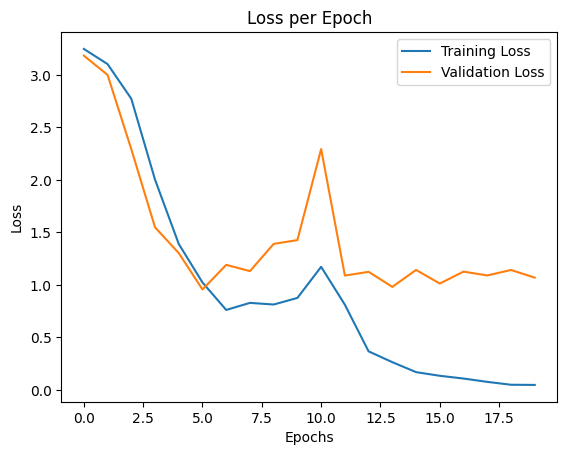

In [8]:
# Fine-tuning the model
save_directory = './dsm_finetune'
os.makedirs(save_directory, exist_ok=True)

criterion = nn.CrossEntropyLoss()

optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)

total_steps = len(train_loader) * 20
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.9)

scaler = GradScaler()

train_loss_values = []
val_loss_values = []

epochs = 20
patience = 3
no_improvement = 0
best_f1 = 0

print("Starting training...")

# Training loop
for epoch in range(epochs):
    if no_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}.")
        break

    total_train_loss = 0
    model.train()

    # Training phase
    for step, batch in enumerate(train_loader):
        input_ids = batch["input_ids"].to(device)
        attention_masks = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()

        with autocast():
            outputs = model(input_ids, attention_mask=attention_masks)
            loss = criterion(outputs.logits, labels)

        total_train_loss += loss.item()

        # Backpropagation
        scaler.scale(loss).backward()
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

    # Compute average training loss
    avg_train_loss = total_train_loss / len(train_loader)
    train_loss_values.append(avg_train_loss)

    # Validation phase
    avg_loss, accuracy, precision, recall, f1, _ = evaluate_model(model, val_loader, label_to_details)
    val_loss_values.append(avg_loss)

    # Adjust learning rate based on validation loss
    scheduler.step(avg_loss)

    print(f'\nEpoch {epoch + 1}')
    print(f'Loss: {avg_loss:.4f}  Accuracy: {accuracy * 100:.2f}%  Precision: {precision * 100:.2f}%  Recall: {recall * 100:.2f}%  F1: {f1 * 100:.2f}%')

    # Check for improvement
    if f1 > best_f1:
        improvement = f1 - best_f1
        print(f"F1 improvement: {improvement * 100:.2f}% ..saving model...")
        best_f1 = f1
        no_improvement = 0  # Reset the no improvement counter

        # Save the LoRA adapter configuration and weights
        adapter_save_path = os.path.join(save_directory, 'adapter')
        model.save_pretrained(adapter_save_path)

        # Save tokenizer and other model-related files
        tokenizer.save_pretrained(save_directory)
        config = AutoConfig.from_pretrained(model_name)
        config.save_pretrained(save_directory)

        # Save label mapping
        with open(os.path.join(save_directory, 'label_mapping.json'), 'w') as f:
            json.dump(label_mapping, f)

        # Save training metadata
        training_metadata = {
            "learning_rate": optimizer.param_groups[0]['lr'],
            "epochs": epochs,
            "batch_size": train_loader.batch_size,
            "total_steps": total_steps,
            "best_f1": best_f1,
            "gradient_clipping": 1.0,
            "weight_decay": optimizer.param_groups[0].get('weight_decay', 0),
            "scheduler": str(scheduler.__class__.__name__)
        }
        with open(os.path.join(save_directory, 'training_metadata.json'), 'w') as f:
            json.dump(training_metadata, f)

        # Save best evaluation metrics
        best_metrics = {
            "f1_score": best_f1,
            "precision": precision,
            "recall": recall,
            "accuracy": accuracy
        }
        with open(os.path.join(save_directory, 'evaluation_metrics.json'), 'w') as f:
            json.dump(best_metrics, f)

    else:
        no_improvement += 1
        print(f"No F1 improvement at epoch {epoch+1}. Early stopping counter: {no_improvement}/{patience}")

print("Training completed. Best model saved.\n")

# Plot training and validation loss
plt.plot(train_loss_values, label="Training Loss")
plt.plot(val_loss_values, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.show()

In [12]:
# Testing the fine-tuned model against the test set
save_directory = './dsm_finetune'
model_name = "emilyalsentzer/Bio_ClinicalBERT"
base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

model = PeftModel.from_pretrained(base_model, os.path.join(save_directory, 'adapter')).to(device)
model.eval()

print("Starting evaluation...\n")
avg_loss, accuracy, precision, recall, f1, _ = evaluate_model(model, test_loader, label_to_details)
print('Evaluation Results:')
print(f'Loss: {avg_loss:.2f}')
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1: {f1 * 100:.2f}%')

Starting evaluation...

Evaluation Results:
Loss: 1.29
Accuracy: 91.30%
Precision: 91.49%
Recall: 91.30%
F1: 91.23%


In [13]:
# Saving test evaluation results
evaluation_results = {
    "loss": f'{avg_loss * 100:.2f}%',
    "accuracy": f'{accuracy * 100:.2f}%',
    "precision": f'{precision * 100:.2f}%',
    "recall": f'{recall * 100:.2f}%',
    "f1": f'{f1 * 100:.2f}%'
}
with open(os.path.join(save_directory, 'test_evaluation_results.json'), 'w') as f:
    json.dump(evaluation_results, f)
print("Evaluation results saved to test_evaluation_results.json")

Evaluation results saved to test_evaluation_results.json


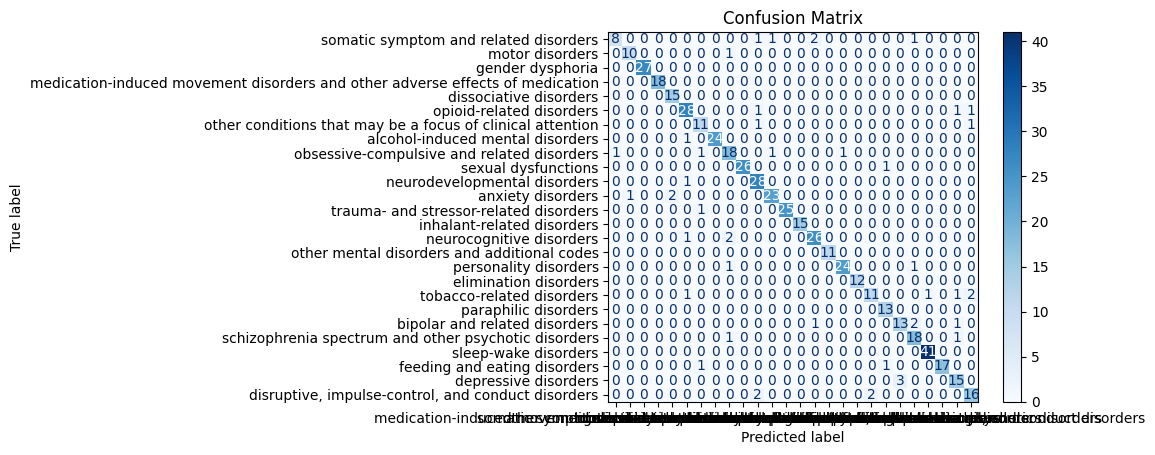

In [14]:
# Get predictions for the test set with confusion matrix report
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_masks = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_masks)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[label for label, _ in label_mapping.items()])

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [16]:
diagnosis_labels = list(label_mapping.keys())
def predict_diagnoses(texts, diagnosis_labels, label_to_details):
    """Predicts diagnoses with confidence scores and detailed outputs."""
    predictions = []
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(device)
    outputs = model(**inputs)
    logits = outputs.logits
    confidences, predicted_class_ids = torch.softmax(logits, dim=-1).max(dim=1)

    for idx, predicted_class_id in enumerate(predicted_class_ids.tolist()):
        predicted_diagnosis = diagnosis_labels[predicted_class_id]  # Get broad category
        details = label_to_details.get(predicted_class_id, {"category": "Unknown", "description": "No description available."})
        predictions.append({
            "broad_category": predicted_diagnosis,
            "confidence": confidences[idx].item(),
            "category": details["category"],
            "description": details["description"]
        })

    return predictions

In [28]:

diagnosis_labels = list(label_mapping.keys())

texts = [
    "I've been feeling down and hopeless for the past few weeks.",
    "I get anxious in social situations and avoid them as much as I can.",
    "I can't seem to focus and often forget things easily.",
    "I have been overeating and feel guilty about it.",
    "I can't sleep at night and wake up feeling anxious every morning.",
    "Patient reports he feels preoccupation with having or acquiring a serious illness",
    "a tic is a sudden, rapid, recurrent, nonrhythmic motor movement or vocalization. tourettes disorder",
    "many individuals with mild to moderate tic severity experience no distress or impairment in functioning and may even be unaware of their tics. individuals with more severe symptoms generally have more",
    "males are more commonly affected than females, but there are no sex differences in the kinds of tics, age at onset, or course. women with persistent tic disorders may be more likely to experience anxiety and depression."
]

predictions = predict_diagnoses(texts, diagnosis_labels, label_to_details)

# Print predictions
for idx, prediction in enumerate(predictions):
    print(f"Input Text: {texts[idx]}")
    print(f"Broad Category: {prediction['broad_category']}")
    print(f"Confidence: {prediction['confidence'] * 100:.2f}%")
    print(f"Category: {prediction['category']}")
    print(f"Description: {prediction['description']}\n")


Input Text: I've been feeling down and hopeless for the past few weeks.
Broad Category: depressive disorders
Confidence: 98.81%
Category: depressive disorders > unspecified mood disorder > description
Description: this category applies to presentations in which symptoms characteristic of a mood disorder that cause clinically significant distress or impairment in social, occupational, or other important areas of functioning predominate but do not at the time of the evaluation meet the full criteria for any of the disorders in either the bipolar or the depressive disorders diagnostic classes and in which it is difficult to choose between unspecified bipolar and related disorder and unspecified depressive disorder (e.g., acute agitation). specifiers for depressive disorders specify if: with anxious distress: anxious distress is defined as the presence of at least two of the following symptoms during the majority of days of the current major depressive episode (or the most recent major dep

In [38]:
# Create a mapping: broad_category -> list of associated categories
category_mapping = data.groupby('broad_category')['category'].apply(list).to_dict()

# Optionally include descriptions
category_to_description = data.set_index('category')['description'].to_dict()


In [33]:
from difflib import SequenceMatcher

def similarity(a, b):
    """Compute a similarity score between two strings using SequenceMatcher."""
    return SequenceMatcher(None, a, b).ratio()

def heuristic_match(text, predicted_broad_category):
    """
    Match the input text to the best category within the predicted broad category.
    """
    candidate_categories = category_mapping.get(predicted_broad_category, [])
    if not candidate_categories:
        return {"category": "Unknown", "description": "No candidates available."}

    # Initialize best match variables
    best_match = None
    best_score = 0.0

    # Iterate over candidate categories
    for category in candidate_categories:
        description = category_to_description.get(category, "")
        # Calculate similarity between input text and category description
        score = similarity(text, description)
        if score > best_score:
            best_match = category
            best_score = score

    return {
        "category": best_match or "Unknown",
        "description": category_to_description.get(best_match, "No description available."),
        "similarity_score": best_score
    }


In [34]:
def predict_with_heuristic(texts, diagnosis_labels):
    """Predict broad category and refine with heuristic match for categories."""
    predictions = []
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(device)
    outputs = model(**inputs)
    logits = outputs.logits
    confidences, predicted_class_ids = torch.softmax(logits, dim=-1).max(dim=1)

    for idx, predicted_class_id in enumerate(predicted_class_ids.tolist()):
        predicted_diagnosis = diagnosis_labels[predicted_class_id]  # Broad category
        # Apply heuristic match for subcategory
        heuristic_result = heuristic_match(texts[idx], predicted_diagnosis)
        predictions.append({
            "broad_category": predicted_diagnosis,
            "confidence": confidences[idx].item(),
            **heuristic_result  # Add category, description, similarity_score
        })

    return predictions


In [39]:
# Example input texts
texts = [
    "Males are more commonly affected than females, but there are no sex differences in the kinds of tics.",
    "I've been feeling down and hopeless for the past few weeks."
]

# Predict with heuristic refinement
results = predict_with_heuristic(texts, list(label_mapping.keys()))

# Display results
for result in results:
    print(f"Input Text: {texts[results.index(result)]}")
    print(f"Broad Category: {result['broad_category']} (Confidence: {result['confidence']:.2f}%)")
    print(f"Category: {result['category']}")
    print(f"Description: {result['description']}")
    print(f"Similarity Score: {result['similarity_score']:.2f}")
    print()


Input Text: Males are more commonly affected than females, but there are no sex differences in the kinds of tics.
Broad Category: motor disorders (Confidence: 1.00%)
Category: motor disorders > tic disorders > sex- and gender-related diagnostic issues
Description: males are more commonly affected than females, but there are no sex differences in the kinds of tics, age at onset, or course. women with persistent tic disorders may be more likely to experience anxiety and depression.
Similarity Score: 0.62

Input Text: I've been feeling down and hopeless for the past few weeks.
Broad Category: depressive disorders (Confidence: 0.99%)
Category: depressive disorders > premenstrual dysphoric disorder > association with suicidal thoughts or behavior
Description: the premenstrual phase has been considered by some to be a risk period for suicide.
Similarity Score: 0.32



In [20]:
def get_clinician_feedback(predicted_diagnosis, actual_diagnosis, text):
    """Gathers feedback from a clinician."""

    print(f"\nPredicted Diagnosis: {predicted_diagnosis}")
    print(f"Actual Diagnosis: {actual_diagnosis}")
    print(f"Patient Description: {text}\n")

    feedback = input("Clinician feedback (e.g., agreement, insights, concerns): ")
    return feedback

def explain_and_evaluate_for_clinicians(model, tokenizer, case_data, device): #Updated function signature
    """
    Explains predictions and collects clinician feedback for a LoRA-tuned model.

    Args:
        model: The fine-tuned model (loaded with LoRA adapter). # Updated parameter description
        tokenizer: The tokenizer used for the model.
        case_data: A list of dictionaries, each containing:
            'text': The patient's text description.
            'diagnosis': The actual diagnosis (ground truth).
        device: The device to run the model on (e.g., 'cuda' or 'cpu').

    Returns:
        A list of clinician feedback for each case.
    """

    clinician_feedback = []

    for case in case_data:
        text = case['text']
        actual_diagnosis = case['diagnosis']

        inputs = tokenizer(text, return_tensors='pt').to(device)
        with torch.no_grad():
            outputs = model(**inputs) # Using the provided model
        prediction_idx = outputs.logits.argmax().item()

        predicted_diagnosis = [key for key, value in label_mapping.items() if value == prediction_idx][0]

        # Collect feedback (using get_clinician_feedback)
        feedback = get_clinician_feedback(predicted_diagnosis, actual_diagnosis, text)
        clinician_feedback.append(feedback)

    return clinician_feedback

In [22]:
case_data = [
    {'text': "Patient presents with fever, cough, and shortness of breath...", 'diagnosis': 'Pneumonia'},
    {'text': "Patient reports severe headache and stiff neck...", 'diagnosis': 'Meningitis'},
    # ... more cases ...
]

feedback_list = explain_and_evaluate_for_clinicians(model, tokenizer, case_data, device)

# Print the collected feedback
for i, feedback in enumerate(feedback_list):
    print(f"Feedback for Case {i + 1}: {feedback}")


Predicted Diagnosis: tobacco-related disorders
Actual Diagnosis: Pneumonia
Patient Description: Patient presents with fever, cough, and shortness of breath...

Clinician feedback (e.g., agreement, insights, concerns): close

Predicted Diagnosis: depressive disorders
Actual Diagnosis: Meningitis
Patient Description: Patient reports severe headache and stiff neck...

Clinician feedback (e.g., agreement, insights, concerns): false
Feedback for Case 1: close
Feedback for Case 2: false
